<h1 style="text-align:center;">Speech Processing - Speaker Diarization</h1>
<h3 style="text-align:center;">ICSI Meeting Corpus</h3>

#### **Offline Diarization System**

#### Load and Preprocess Audio Data

In [1]:
import struct
import wave
import pvcobra
from scipy.io.wavfile import write
import librosa
import numpy as np
from matplotlib import pyplot as plt
import random

def read_file(file_name, sample_rate):
    wav_file = wave.open(file_name, mode="rb")
    channels = wav_file.getnchannels()
    num_frames = wav_file.getnframes()

    if wav_file.getframerate() != sample_rate:
        raise ValueError("Audio file should have a sample rate of %d. Got %d" % (sample_rate, wav_file.getframerate()))

    samples = wav_file.readframes(num_frames)
    wav_file.close()

    frames = struct.unpack('h' * num_frames * channels, samples)

    if channels == 2:
        print("Picovoice processes single-channel audio but stereo file is provided. Processing left channel only.")

    return frames[::channels]

#### 1) Voice Activity Detection

In [2]:
input_wav_path = 'J:/Speech-Project/speaker-diarization-resampled.wav'
access_key = 'RvEwFJ9Xap8Ln6o+u9t5hRMs7Exh81PHsX0z7rapGCN/LGqkVnnl5g=='
threshold = 0.8

cobra = pvcobra.create(access_key=access_key)

print("Cobra version: %s" % cobra.version)
audio = read_file(input_wav_path, cobra.sample_rate)

num_frames = len(audio) // cobra.frame_length
results = []

voice_segments = []
segment = []
for i in range(num_frames):
    frame = audio[i * cobra.frame_length:(i + 1) * cobra.frame_length]
    result = cobra.process(frame)
    if result >= threshold:
        segment.extend(frame)
    else:
        if segment:
            voice_segments.append(segment)
            segment = []

if segment:
    voice_segments.append(segment)

for idx, segment in enumerate(voice_segments):
    segment = np.array(segment, dtype=np.int16)
    write(f'VAD_segments/segment_{idx}.wav', cobra.sample_rate, segment)

cobra.delete()

Cobra version: 2.0.0
Picovoice processes single-channel audio but stereo file is provided. Processing left channel only.


#### 2) MFCC based feature extraction

In [ ]:
def extract_mfcc(audio_file, sr=16000, n_mfcc=64):
    y, sr = librosa.load(audio_file, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfccs

mfcc_features = []

for idx in range(len(voice_segments)):
    segment_file = f'VAD_segments/segment_{idx}.wav'
    mfccs = extract_mfcc(segment_file, sr=cobra.sample_rate)
    mfcc_features.append(mfccs)

#### MFCC Visualization

In [ ]:
# Plot MFCCs for the chosen segment
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_features[0], x_axis='time')
plt.colorbar()
plt.title(f'MFCCs of Segment {0}')
plt.ylabel('MFCC Coefficients')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

#### 3) Speaker Embedding using **deep_speaker**

In [3]:
# Initialize the DeepSpeaker model
from deep_speaker.audio import read_mfcc
from deep_speaker.batcher import sample_from_mfcc
from deep_speaker.constants import SAMPLE_RATE, NUM_FRAMES
from deep_speaker.conv_models import DeepSpeakerModel
from deep_speaker.test import batch_cosine_similarity

# Reproducible results.
np.random.seed(123)
random.seed(123)

# Initialize the DeepSpeaker model
model = DeepSpeakerModel()

# Load pre-trained weights
model.m.load_weights("J:/Speech-Project/ResCNN_triplet_training_checkpoint_265.h5", by_name=True)

import os

# Path to the directory containing VAD segments
vad_segments_dir = 'VAD_segments/'

# Initialize lists to store speaker embeddings and filenames
embeddings = []
file_names = []

# Iterate over all files in the VAD_segments directory
for file_name in os.listdir(vad_segments_dir):
    # Read MFCC features from the VAD segment
    mfcc = sample_from_mfcc(read_mfcc(os.path.join(vad_segments_dir, file_name), SAMPLE_RATE), NUM_FRAMES)
    
    # Get the speaker embedding for the MFCC features
    embedding = model.m.predict(np.expand_dims(mfcc, axis=0))
    
    # Append the embedding and filename to the respective lists
    embeddings.append(embedding)
    file_names.append(file_name)

# Convert lists to numpy arrays
embeddings = np.array(embeddings)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━

In [4]:
# Convert lists to numpy arrays
embeddings = np.array(embeddings)

# Print the shape of the obtained embeddings
print('Shape of speaker embeddings:', embeddings.shape)

Shape of speaker embeddings: (37, 1, 512)


#### T-SNE Visualization of Speaker Embeddings

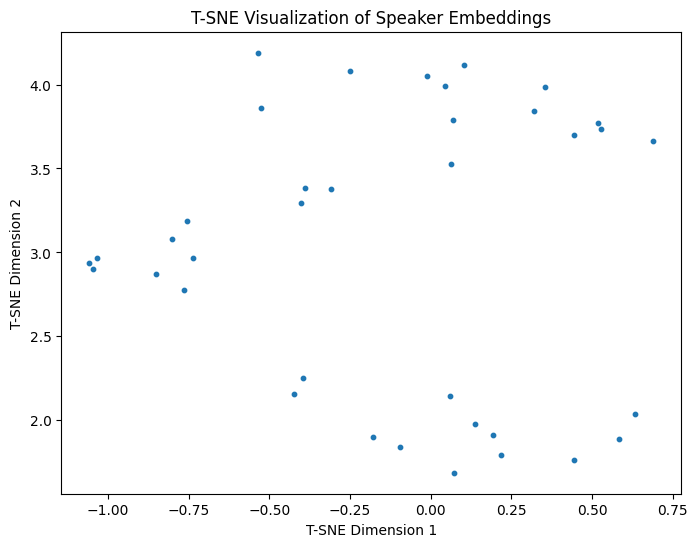

In [5]:
from sklearn.manifold import TSNE

# Flatten the embeddings if needed (remove the singleton dimension)
embeddings = np.squeeze(embeddings)

# Apply T-SNE to reduce dimensions
tsne = TSNE(n_components=2, random_state=123)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the 2D embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=10)
plt.title('T-SNE Visualization of Speaker Embeddings')
plt.xlabel('T-SNE Dimension 1')
plt.ylabel('T-SNE Dimension 2')
plt.show()

#### **4)Clustering**

#### Finding the numbers of speakers in the meeting

In [6]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

from kneed import KneeLocator

# Reshape the embeddings to remove the extra dimension
embeddings = embeddings.reshape(37, 512)

k_range = range(2, 11)  # You can adjust this range as needed

inertia = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)

# Use the KneeLocator to find the elbow point
knee = KneeLocator(k_range, inertia, curve="convex", direction="decreasing")
optimal_k = knee.elbow
print(f"Optimal k value: {optimal_k}")

Optimal k value: 3


#### Training and Visualization

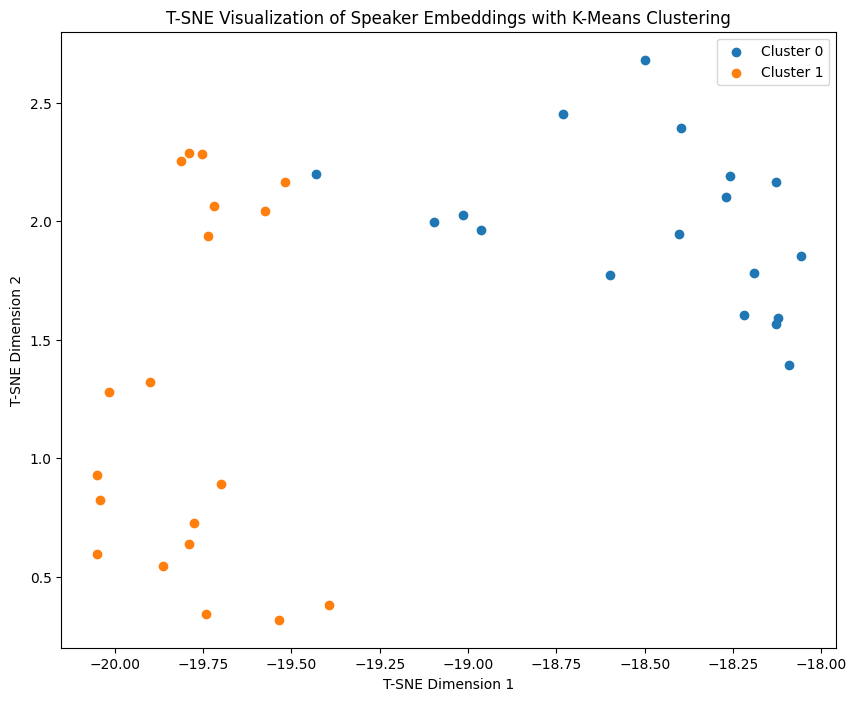

In [7]:
# Perform K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Visualize the clusters using T-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(2):
    plt.scatter(embeddings_2d[cluster_labels == i, 0], embeddings_2d[cluster_labels == i, 1], label=f'Cluster {i}')
plt.title('T-SNE Visualization of Speaker Embeddings with K-Means Clustering')
plt.xlabel('T-SNE Dimension 1')
plt.ylabel('T-SNE Dimension 2')
plt.legend()
plt.show()

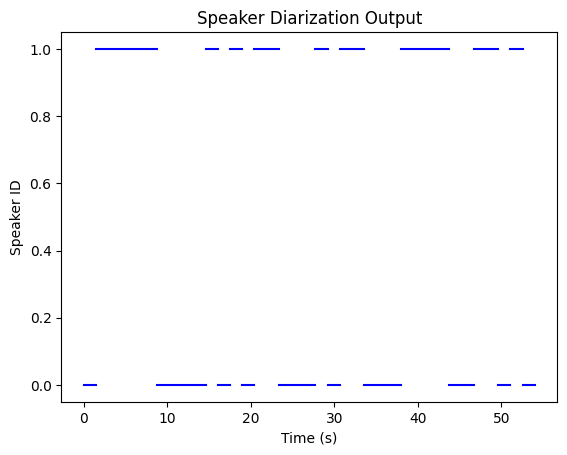

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'embeddings' contains the speaker embeddings and 'cluster_labels' contains the cluster labels assigned by K-means

# Assign cluster IDs
cluster_ids = kmeans.labels_

# Assign Speaker IDs
def assign_speaker_ids(cluster_ids):
    unique_clusters, counts = np.unique(cluster_ids, return_counts=True)
    speaker_ids = {cluster: i for i, cluster in enumerate(unique_clusters)}
    return np.array([speaker_ids[cluster] for cluster in cluster_ids])

speaker_ids = assign_speaker_ids(cluster_ids)

# Speaker Segmentation
def speaker_segmentation(speaker_ids):
    segments = []
    current_segment = []
    current_speaker = speaker_ids[0]
    for i, speaker in enumerate(speaker_ids):
        if speaker == current_speaker:
            current_segment.append(i)
        else:
            segments.append((current_segment[0], current_segment[-1], current_speaker))
            current_segment = [i]
            current_speaker = speaker
    segments.append((current_segment[0], current_segment[-1], current_speaker))
    return segments

segments = speaker_segmentation(speaker_ids)

# Time Index Calculation
def calculate_time_index(segments, duration, num_segments):
    time_index = []
    for start, end, speaker in segments:
        start_time = start * (duration / num_segments)
        end_time = (end + 1) * (duration / num_segments)
        time_index.append((start_time, end_time, speaker))
    return time_index

duration = 54  # Duration of the meeting video in seconds
num_segments = len(embeddings)
time_index = calculate_time_index(segments, duration, num_segments)

# Plot Visualization
for start, end, speaker in time_index:
    plt.plot([start, end], [speaker, speaker], color='blue')  # Plotting speaker ID over time

plt.xlabel('Time (s)')
plt.ylabel('Speaker ID')
plt.title('Speaker Diarization Output')
plt.show()


In [12]:
from sklearn.metrics import silhouette_score

# Assuming embeddings_2d and labels are obtained from the previous steps
silhouette_avg = silhouette_score(embeddings_2d, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.2f}')

Silhouette Score: 0.49
